This notebook is put together by [Qingkai Kong](http://seismo.berkeley.edu/qingkaikong/) from [Berkeley Seismology Lab](http://seismo.berkeley.edu). If you have any questions, feel free to contact him via kongqk@berkeley.edu. 

## Example background 

In this tutorial, we will use a simple example - classify noise and earthquake signals. 

I only select one station data, [MNRC](http://seismo.berkeley.edu/station_book/mnrc.html)  from BK network for 20 years (1999-01-01 to 2019-01-01). Seismic data was downloaded for M3 and above within 1 degree, with a window: 5 s before the P wave and 60 second after the P wave. You can find more information about these events in the data folder (EQs_M3_above.csv). Noise data was downloaded based on the 1 hour time gaps that have no earthquakes occured within it. I make the datasets into a balanced dataset, which means that the number of seismic waveforms is the same as that of the noise waveforms. 

In this tutorial, I will cover what we just learned to train an artificial neural network (ANN) model to classify the seismic signal and noise. I will show the basic steps of how to train a model, from preparing the training data, train/test split, preprocessing, feature selection, hyperparameter tunning to evaluate the model performance. 

Of course, within this short time workshop, we can not cover everything, but hope this small tutorial notebook can give you a sense how you can easily train a model on your own data. The best way to learn machine learning is to do a project and follow the tutorials examples, both scikit-learn and keras have very good examples that you can improve your skills, do remember to play with them. [Scikit-learn examples](https://scikit-learn.org/stable/auto_examples/index.html) and [Keras Examples](https://github.com/keras-team/keras/tree/master/examples).

In [1]:
# import all the needed module
import itertools
import matplotlib.pyplot as plt
# split the data into train/test
from sklearn.model_selection import train_test_split
# ANN classifier
from sklearn.neural_network import MLPClassifier
# preprocessing
from sklearn.preprocessing import StandardScaler
# evaluation 
from sklearn.metrics import classification_report,confusion_matrix

import numpy as np
import glob
from obspy import read
plt.style.use('seaborn-poster')
# turn off the warnings
import warnings
warnings.filterwarnings("ignore")

## Read in the data

The first step is always reading in the data and plot to get a sense what you are working on.

In [2]:
training_folder = '../data/training_data_classification/'
# prepare data
waveforms = []
labels = []

for item in glob.glob(training_folder + 'seismic/*.mseed'):

    # read in noise data
    st = read(item.replace('seismic', 'noise'))
    st.detrend('demean').detrend('linear')
    
    # skip the data that has less data points
    if st[0].stats.npts < 1626:
        continue
    
    data = np.c_[st[0].data, st[1].data, st[2].data]
    #data = data/data.max(axis = 0)
    waveforms.append(data)
    labels.append(0)
    
    st = read(item)
    st.detrend('demean').detrend('linear')
    data = np.c_[st[0].data, st[1].data, st[2].data]
    # let's do a simple normalize the data
    #data = data/data.max(axis = 0)
    waveforms.append(data)
    labels.append(1)
    
waveforms = np.dstack(waveforms)
y = np.array(labels)
waveforms = waveforms.T

In [3]:
st[0]

BK.MNRC..HHE | 2009-01-04T17:27:11.726869Z - 2009-01-04T17:28:16.726869Z | 25.0 Hz, 1626 samples

In [4]:
waveforms.shape

(528, 3, 1626)

In [5]:
y.shape

(528,)

In [6]:
y

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,

## Let's see some examples of noise and EQ waveforms

From the above we see that the waveforms are saved in the 3D numpy array, the first axis is the number of samples, 2nd axis is the 3 components, and the last axis is the time series. 

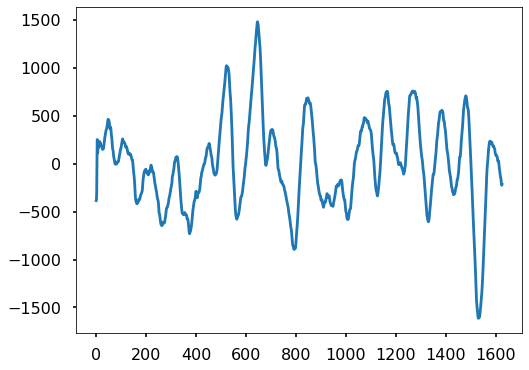

In [7]:
# Noise
plt.figure(figsize = (8, 6))
plt.plot(waveforms[2, 1, :])

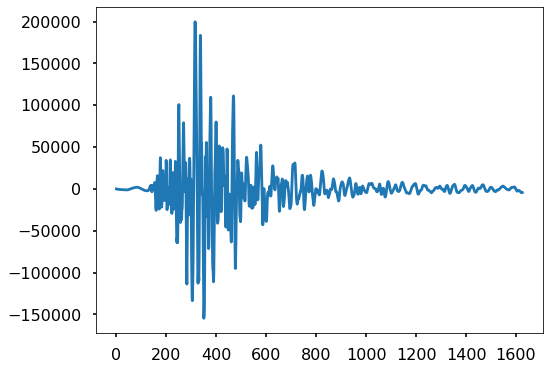

In [8]:
# EQ
plt.figure(figsize = (8, 6))
plt.plot(waveforms[31, 1, :])

In [9]:
waveforms[31, :, :].shape

(3, 1626)

## Extract features

Then we need to put the data into a good format so that we can input into ML algorithms. Different packages usually have different input format. Do check the documentation. Since we are using [scikit-learn](https://scikit-learn.org/stable/), you can find more information in this [tutorial](https://scikit-learn.org/stable/tutorial/basic/tutorial.html). 

We will extract some features and put them into an 2D array with the first axis is number of samples and 2nd axis is the store of different features.

Let's first define a function to calculate just 4 features (of course, you can calculate more, we will only use these 4 features to illustrate the main ideas). These features such as mean value, max value, standard deviation, and number of zero crossings are calculated first on each of the 3 components, and then we only keep the largest one from the 3 components. 

In [10]:
def calculate_features(data):
    
    # Similar features
    mean_amp = np.apply_along_axis(np.mean, 1, np.abs(data))
    max_amp = np.apply_along_axis(max, 1, np.abs(data))
    std_amp = np.apply_along_axis(np.std, 1, data)
    
    # useful features
    zero_crossings = lambda data: len(np.where(np.diff(np.sign(data)))[0])
    zc = np.apply_along_axis(zero_crossings, 1, data)
    
    # non-useful features at all
    duration = len(data[1, :])
    
    return max(mean_amp), max(max_amp), max(std_amp), max(zc), duration

In [11]:
# calculate all the features for each record
X = np.array(list(map(calculate_features, waveforms)))

In [12]:
X.shape

(528, 5)

In [13]:
X

array([[4.35073500e+02, 1.30921414e+03, 5.34333529e+02, 2.80000000e+01,
        1.62600000e+03],
       [1.71581814e+04, 1.48926167e+05, 3.06689114e+04, 1.43000000e+02,
        1.62600000e+03],
       [3.65475995e+02, 1.71893523e+03, 4.74364842e+02, 4.60000000e+01,
        1.62600000e+03],
       ...,
       [6.22365346e+03, 7.50774571e+04, 1.09307569e+04, 1.27000000e+02,
        1.62600000e+03],
       [5.92407756e+02, 2.00972739e+03, 7.22874311e+02, 3.50000000e+01,
        1.62600000e+03],
       [3.68919054e+04, 4.70940491e+05, 6.85142228e+04, 1.14000000e+02,
        1.62600000e+03]])

Text(0, 0.5, 'max_amp')

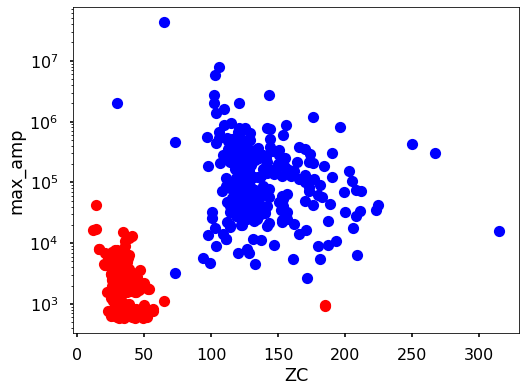

In [14]:
plt.figure(figsize = (8, 6))
for i, c in zip([0, 1], ['r', 'b']):
    ix = y == i 
    plt.plot(X[:, 3][ix], X[:, 1][ix], 'o', color = c)
    plt.yscale('log')
    
plt.xlabel('ZC')
plt.ylabel('max_amp')

Text(0, 0.5, 'mean_amp')

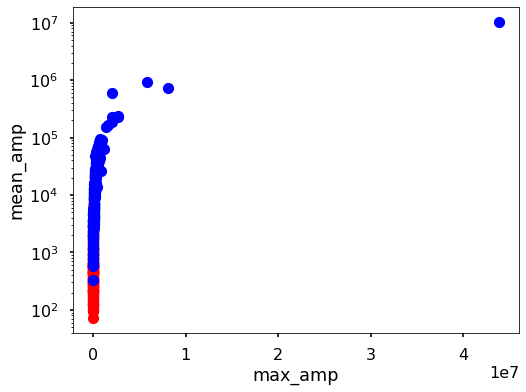

In [15]:
plt.figure(figsize = (8, 6))
for i, c in zip([0, 1], ['r', 'b']):
    ix = y == i 
    plt.plot(X[:, 1][ix], X[:, 0][ix], 'o', color = c)
    plt.yscale('log')
plt.xlabel('max_amp')
plt.ylabel('mean_amp')

## Divide training/testing dataset and preprocessing

We talked before that we should divide the data into training and testing so that we only use the testing data once to evaluate the overall performance. Let's use 20% of our dataset as the testing. Also, for some algorithms, it is better to do some preprocessing. The reason we do this usually is to make sure that no individual feature will dominant the results. You can find more information about preprocessing [here](https://scikit-learn.org/stable/modules/preprocessing.html).  

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 7)

In [17]:
print(len(X_train), len(X_test))

422 106


Here we use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to remove the mean and scale each feature to unit variance. 

In [18]:
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train)

## Feature selection

There are different ways to select the best subset of the features, for example, scikit-learn has various [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) methods that you can easily use for your purposes. Here we will show how we can select the subset number of features achieve our goal. You can find more introduction of feature selection in this important [paper](http://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf). 

In the following, we show you how to use [KFold Crossvalidation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to select the optimal subset of features. Note that, we use SVC to select the features. [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) is another popular algorithm - support vector machine. You can use other algorithms as well, but usually get similar results. This is also to say, if you have a good list of features, usually different algorithms will perform similarly on the data. 

In [20]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

In [21]:
# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)

rfecv = RFECV(estimator=svc, step=1, cv=KFold(2),
              scoring='accuracy')
# Here in order to speed up, we only use the first 50 records for finding the best features
rfecv.fit(X_train_scale, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 2


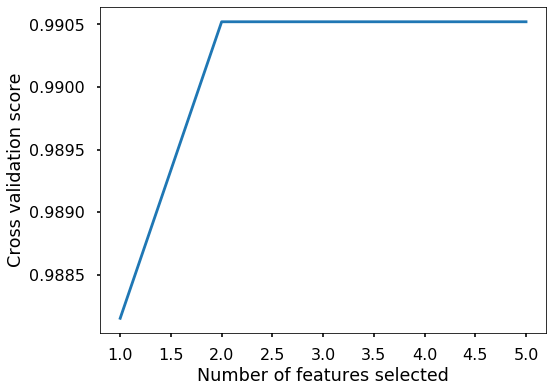

In [22]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize = (8, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [23]:
feature_names = ['mean_amp', 'max_amp', 'std_amp', 'zc', 'duration']
rfecv.ranking_

array([3, 1, 2, 1, 4])

Text(0, 0.5, 'Ranking of the features (1 means selected)')

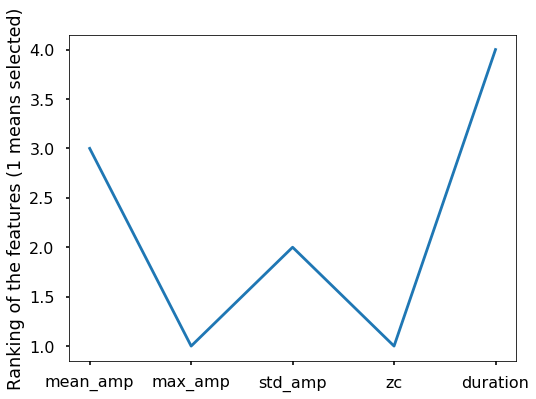

In [24]:
plt.figure(figsize = (8, 6))
plt.plot(rfecv.ranking_)
plt.xticks(range(5), feature_names)
plt.ylabel('Ranking of the features (1 means selected)')

## Train an ANN model

### Tuning hyperparameters

Tuning hyperparameters are important in ML algorithms. Since usually there are many parameters that need to be decided by us (even as of today, there are no ML algorithms that don't have any hyperparameters). We use cross-validation to do this. Also, note that, since we need to run a grid of parameters to determine the best parameter combination, it will take a lot of time if you have a large datasets with complicated models. Especially in today's application using deep learning, sometimes it is hard to determine the hyperparameters using cross-validation. For example, to determine how many layers you need to choose, you can always start with simple model with small number of layers and gradually increase the number of layers until you get a good results. 

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
X_train_select = X_train[:, [1, 3]]
X_test_select = X_test[:, [1, 3]]
# re-normalize the two column data
standard_scaler = StandardScaler()
X_train_scale = standard_scaler.fit_transform(X_train_select)
X_test_scale = standard_scaler.transform(X_test_select)

In [27]:
# Set the parameters by cross-validation
tuned_parameters = [{'hidden_layer_sizes': [(1, ), (2, ), (3, ), (4, ), (1, 1), (2, 2), (3, 3), (4, 4)],
                    'solver': ['adam', 'sgd']}]

In [28]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(MLPClassifier(max_iter = 500, early_stopping=True,validation_fraction=0.2, \
                        tol = 1e-5, n_iter_no_change = 20, learning_rate_init = 0.1, random_state =1), tuned_parameters, cv=5, \
                       scoring='%s_macro' % score)
    clf.fit(X_train_scale, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'hidden_layer_sizes': (2, 2), 'solver': 'adam'}

Grid scores on development set:

0.252 (+/-0.014) for {'hidden_layer_sizes': (1,), 'solver': 'adam'}
0.252 (+/-0.015) for {'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.993 (+/-0.019) for {'hidden_layer_sizes': (2,), 'solver': 'adam'}
0.993 (+/-0.019) for {'hidden_layer_sizes': (2,), 'solver': 'sgd'}
0.979 (+/-0.027) for {'hidden_layer_sizes': (3,), 'solver': 'adam'}
0.984 (+/-0.024) for {'hidden_layer_sizes': (3,), 'solver': 'sgd'}
0.991 (+/-0.018) for {'hidden_layer_sizes': (4,), 'solver': 'adam'}
0.986 (+/-0.023) for {'hidden_layer_sizes': (4,), 'solver': 'sgd'}
0.252 (+/-0.014) for {'hidden_layer_sizes': (1, 1), 'solver': 'adam'}
0.252 (+/-0.014) for {'hidden_layer_sizes': (1, 1), 'solver': 'sgd'}
0.995 (+/-0.012) for {'hidden_layer_sizes': (2, 2), 'solver': 'adam'}
0.991 (+/-0.017) for {'hidden_layer_sizes': (2, 2), 'solver': 'sgd'}
0.995 (+/-0

## Train and Test the model

In [29]:
# Initialize ANN classifier
mlp = MLPClassifier(hidden_layer_sizes=(2, ), max_iter = 500, learning_rate_init = 0.1, \
                    early_stopping=True, validation_fraction=0.2, solver = 'sgd', \
                    tol = 1e-5, n_iter_no_change = 20, verbose = True, random_state = 5)

# Train the classifier with the traning data
mlp.fit(X_train_scale,y_train)

Iteration 1, loss = 0.80109638
Validation score: 0.600000
Iteration 2, loss = 0.69183886
Validation score: 0.882353
Iteration 3, loss = 0.56337878
Validation score: 1.000000
Iteration 4, loss = 0.44894872
Validation score: 1.000000
Iteration 5, loss = 0.37251174
Validation score: 1.000000
Iteration 6, loss = 0.31937013
Validation score: 1.000000
Iteration 7, loss = 0.28298976
Validation score: 1.000000
Iteration 8, loss = 0.25161410
Validation score: 1.000000
Iteration 9, loss = 0.22611573
Validation score: 1.000000
Iteration 10, loss = 0.20505904
Validation score: 1.000000
Iteration 11, loss = 0.18489890
Validation score: 1.000000
Iteration 12, loss = 0.16691964
Validation score: 1.000000
Iteration 13, loss = 0.15235095
Validation score: 1.000000
Iteration 14, loss = 0.13971131
Validation score: 1.000000
Iteration 15, loss = 0.12946594
Validation score: 1.000000
Iteration 16, loss = 0.12116170
Validation score: 1.000000
Iteration 17, loss = 0.11472953
Validation score: 1.000000
Iterat

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(2,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
       random_state=5, shuffle=True, solver='sgd', tol=1e-05,
       validation_fraction=0.2, verbose=True, warm_start=False)

## Evaluate the model

There are various ways to evaluate the model. Here we show you how to get the precision, recall, learning curve, and confusion matrix. 

In [30]:
y_true, y_pred = y_test, mlp.predict(X_test_scale)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       1.00      0.97      0.98        59

   micro avg       0.98      0.98      0.98       106
   macro avg       0.98      0.98      0.98       106
weighted avg       0.98      0.98      0.98       106



In [31]:
classification_report?

Monitoring the training and validation curves are also important. Usually it can tells you when you should stop, and whether your model has overfitting or not. 

Text(0, 0.5, 'Loss')

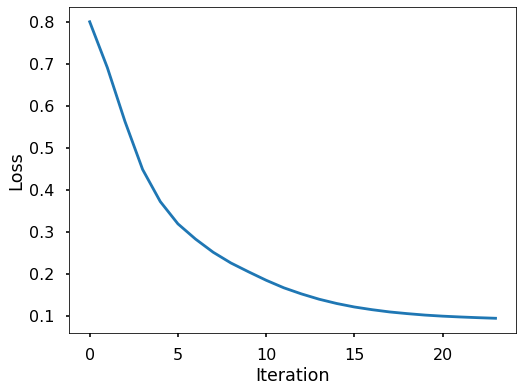

In [32]:
plt.figure(figsize = (8, 6))
plt.plot(mlp.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Validation score')

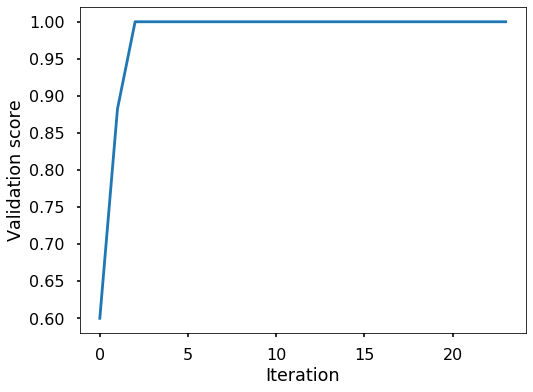

In [33]:
plt.figure(figsize = (8, 6))
plt.plot(mlp.validation_scores_)
plt.xlabel('Iteration')
plt.ylabel('Validation score')

Let's also plot the confusion matrix to see the performance. 

In [34]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[47,  0],
       [ 2, 57]])

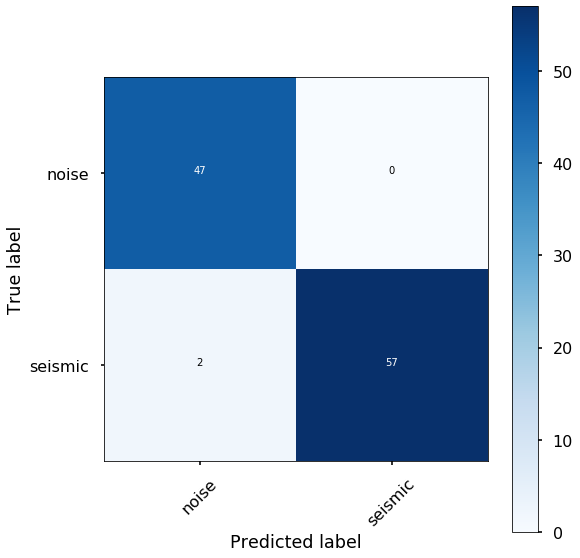

In [35]:
classes = ['noise', 'seismic']

fig = plt.figure(figsize=(8, 8)) 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Plot the decision boundary

In [36]:
X[:, 0].min()

71.47282377242846

In [37]:
# Plotting decision regions
x_min, x_max = X_train_scale[:, 0].min() - 1, X_train_scale[:, 0].max() + 1
y_min, y_max = X_train_scale[:, 1].min() - 1, X_train_scale[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

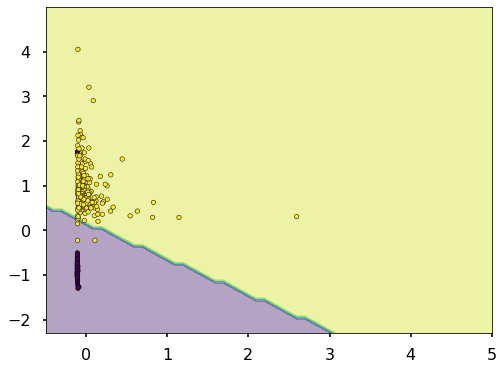

In [38]:
plt.figure(figsize = (8, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_scale[:, 0], X_train_scale[:, 1], c=y_train,
                                  s=20, edgecolor='k')
plt.xlim(-0.5, 5)
plt.show()

There are many great books and tutorials online, here I list three books that helped me a lot in terms of practical guide.

* [Python machine learning](https://www.amazon.com/dp/B0742K7HYF/ref=sspa_dk_detail_0?psc=1) 
* [Deep learning with Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/ref=sr_1_3?keywords=deep+learning+python&qid=1555196961&s=gateway&sr=8-3) 
* [Machine Learning - An Algorithmic Perspective](https://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html)